In [1]:
import cv2 as cv
import numpy as np
import imutils
import matplotlib.pyplot as plt
from collections import namedtuple
import pytesseract

def grayscale(img):
    return cv.cvtColor(img,cv.COLOR_BGR2GRAY)

def threshold(img):
    thresh = cv.threshold(img, 0, 255,
	cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    return thresh


def remove_noise(image):
    return cv.medianBlur(image,5)


#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    return rotated

    
def img_preprocessing(path):
    img = cv.imread(path)
    gray = grayscale(img)
    thresh = threshold(gray)
    unnoise = remove_noise(thresh)
    deskewed = deskew(unnoise)
    return deskewed


In [2]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2,
	debug=False):
	# convert both the input image and template to grayscale
	imageGray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
	templateGray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    # use ORB to detect keypoints and extract (binary) local
	# invariant features
	orb = cv.ORB_create(maxFeatures)
	(kpsA, descsA) = orb.detectAndCompute(imageGray, None)
	(kpsB, descsB) = orb.detectAndCompute(templateGray, None)
	# match the features
	method = cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
	matcher = cv.DescriptorMatcher_create(method)
	matches = matcher.match(descsA, descsB, None)	# sort the matches by their distance (the smaller the distance,
	# the "more similar" the features are)
	matches = sorted(matches, key=lambda x:x.distance)
	# keep only the top matches
	keep = int(len(matches) * keepPercent)
	matches = matches[:keep]
	# check to see if we should visualize the matched keypoints
	if debug:
		matchedVis = cv.drawMatches(image, kpsA, template, kpsB,
			matches, None)
		matchedVis = imutils.resize(matchedVis, width=1000)
		cv.imshow("Matched Keypoints", matchedVis)
		cv.waitKey(0)# allocate memory for the keypoints (x, y)-coordinates from the
	# top matches -- we'll use these coordinates to compute our
	# homography matrix
	ptsA = np.zeros((len(matches), 2), dtype="float")
	ptsB = np.zeros((len(matches), 2), dtype="float")
	# loop over the top matches
	for (i, m) in enumerate(matches):
		# indicate that the two keypoints in the respective images
		# map to each other
		ptsA[i] = kpsA[m.queryIdx].pt
		ptsB[i] = kpsB[m.trainIdx].pt
	# compute the homography matrix between the two sets of matched
	# points
	(H, mask) = cv.findHomography(ptsA, ptsB, method=cv.RANSAC)
	# use the homography matrix to align the images
	(h, w) = template.shape[:2]
	aligned = cv.warpPerspective(image, H, (w, h))
	# return the aligned image
	return aligned

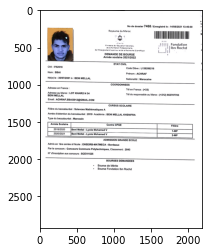

In [3]:
im = cv.imread(f"C:/Users/PC2/Downloads/image.jpg")
temp = cv.imread(f"C:/Users/PC2/Downloads/template.jpeg")
plt.imshow(align_images(im,temp))

In [4]:

def field_location(fields_dict):
    """
    Prend un dictionnaire contenant le nom de la case comme clé et comme valeur un tuple : (x du coin haut gauche,y du coin haut gauche,largeur,longueur)
    les coordonées peuvent etre determinés à l'aide d'un logiciel de modification de photo
    """
    OCR_LOCATION = namedtuple("OCR_LOCATION",["id","coord"])
    OCR_LOCATIONS = []
    for key,value in fields_dict.items():
        ocr = OCR_LOCATION(key,value)
        OCR_LOCATIONS.append(ocr)
    return OCR_LOCATIONS



def ocr(image,template,fields_dict):
    aligned = align_images(image,template)
    OCR_LOCATIONS = field_location(fields_dict)
    parsing_results = []
    
    for loc in OCR_LOCATIONS:
        (x,y,w,h)= loc.coord
        roi = aligned[y:y + h, x:x + w]
        rgb = cv.cvtColor(roi, cv.COLOR_BGR2RGB)
        text = pytesseract.image_to_string(rgb)#tesseract expects an rgb
        lines = []
        for line in text.split("\n"):
            if len(line)==0:
                continue
            lines.append(line)
        parsing_results.append({loc.id:line})

In [5]:
def ocr(image,template,OCR_LOCATIONS):
    aligned = align_images(image,template)
    parsing_results = []
    
    for loc in OCR_LOCATIONS:
        (x,y,w,h)= loc.coord
        roi = aligned[y:y + h, x:x + w]
        
        rgb = cv.cvtColor(roi, cv.COLOR_BGR2RGB)
        text = pytesseract.image_to_string(rgb)#tesseract expects an rgb
        lines = []
        for line in text.split("\n"):
            if len(line)==0:
                continue
            lines.append(line)
        parsing_results.append({loc.id:lines})
    return parsing_results

OCR_LOCATION = namedtuple("OCR_LOCATION",["id","coord"])
OCR_LOCATIONS = [
	OCR_LOCATION("first_name", (1297,833,166, 40)),
    OCR_LOCATION("nationality", (1335,920,200,35)),
    OCR_LOCATION("email", (209,1191,546,36)),
    OCR_LOCATION("Tel", (1598,1121,300,48))

]

ocr(im,temp,OCR_LOCATIONS)

[{'first_name': ['ACHRAF']},
 {'nationality': ['Marocaine']},
 {'email': ['ACHRAF.SBAI2Z012@GMAIL.COM']},
 {'Tel': ['(+212) 662707703']}]